# Generate point cloud and estimate normals

In [1]:
import open3d as o3d
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.manifold import MDS
from matplotlib import pyplot as plt
import os

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Import the coordinates and the features that have been generated by dMaSIF-site

%cd -q masif_site_outputs
%cd -q masif_site_outputs
coords = np.load("1fcc_A_predcoords.npy")
features = np.load("1fcc_A_predfeatures_emb1.npy")


[WinError 2] The system cannot find the file specified: 'masif_site_outputs'


In [3]:
#create a PointCloud and add the points

pointcloud = o3d.geometry.PointCloud()
pointcloud.points = o3d.utility.Vector3dVector(coords)
#o3d.visualization.draw_geometries([pointcloud])

# Estimate the normals based on knn
pointcloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn = 5))
pointcloud.orient_normals_consistent_tangent_plane(k=5)
#o3d.visualization.draw_geometries([pointcloud], point_show_normal = True)

#Extract the normals as numpy array
normals = np.asarray(pointcloud.normals)

# Select a center point around which to extract a geodesic patch

In [4]:
#Select a random point of the cloud, around which to draw a geodesic circle, set a geodesic radius
radius = 12
center_index = 4419 #random.randint(0, len(coords)-1) 
center_coords = coords[center_index]
center_norm = normals[center_index]

In [5]:
center_index, center_coords, center_norm

(4419,
 array([22.53147   , -0.40817997, -5.9581976 ], dtype=float32),
 array([-0.74979539, -0.64154951, -0.16192934]))

# Select all points that are close to the center point and generate a graph

In [6]:
# Make a rough first selection with all points with euclidean distance < radius

first_sel = [center_index] # to save all the points that are within the non-geodesic radius
eucl_dist_to_center = []

#loop through all the points and check what their distance to the selected center point is
for index, point in enumerate(coords):
    dist = np.linalg.norm(coords[center_index]-point)
    eucl_dist_to_center.append(dist)

    # select only those points that are close to the center point and calculate their geodesic distance
    if dist < radius and dist != 0:
        first_sel.append(index)
        
coords_sel = coords[first_sel]


In [7]:
def generate_graph(indeces, coords_sel, normals):

    '''Function that takes a set of points, with their label, coordinates and surface normals. Calculates for each point the 
    geodesic distance to its n nearest neighbors and saves that information in a dictionary representing a graph. '''
    
    graph = {p:{} for p in indeces}

    knn = NearestNeighbors(n_neighbors=8)
    knn.fit(coords_sel)
    
    #loop through each point that is within the radius and find its nearest neighbors and their euclidean distance
    for idx, point in enumerate(coords_sel):
        dist, neighbors = knn.kneighbors([point], return_distance=True)
                
        # loop through the nearest neighbors, calculate their geodesic distance to the point chosen above
        # Add the geodesic distance to a graph-dictionary
        
        for index, neighbor in enumerate(neighbors[0]):
            
            geo_dist = dist[0][index]*(2-np.dot(normals[indeces[idx]], normals[indeces[neighbor]]))        

            if geo_dist !=0:
                graph[indeces[idx]][indeces[neighbor]]=geo_dist
                graph[indeces[neighbor]][indeces[idx]]=geo_dist

    return graph

In [8]:
graph = generate_graph(first_sel, coords_sel, normals)

# Run dijkstra algorithm on the graph and find the geodesic distance of each node to the center node

In [9]:
def distances_from_center(graph, center):
    
    '''Function that takes a graph and the starting node and returns a list of distances 
    from the starting node to every other node'''

    n = len(graph) # How many nodes are in the graph?
    
    # initialize a dictionary to save the distances of each node from the start node
    dist_from_center = {key:100 for key in graph}
        
    # initialize a dictionary to save which node has been visited already
    visited = {key:False for key in graph}
            
    # set the distance for the start to be 0
    dist_from_center[center] = 0
    
    
    for p in range(n):
        
        
        # loop through all the nodes to check which one is not yet visited and has the lowest distance to the current node
        u = -1
        for key in graph:
            # if the node 'key' hasn't been visited and
            # we haven't processed it or the distance we have for it is less
            # than the distance we have to the "start" node
            
            # our start node (4557) will be selected first and assigned to u
            if not visited[key] and (u == -1 or dist_from_center[key] < dist_from_center[u]):
                u = key 
        
        
        # all the nodes have been visited or we can't reach this node
        if dist_from_center[u] == 1000:
            #print("break")
            break
        
        # set the node as visited
        visited[u] = True
        
        # from the current selected node u, check what the distances to the next nodes are and update their dist from center
        # loop through all the points (and their weights) that can be reached from our current node
        for key in graph[u]:
            if dist_from_center[u] + graph[u][key] < dist_from_center[key]:
                dist_from_center[key]= dist_from_center[u] + graph[u][key]
    
    return dist_from_center    


In [10]:
dist_from_center = distances_from_center(graph, center_index)

## Keep only the points that are within the geodesic radius. Use the results of the djikstra algorithm

In [11]:
# Collect the indeces of the points that are < radius away from the center point
patch_indeces = []

for key in dist_from_center:
    if dist_from_center[key]<=radius:
        patch_indeces.append(key)
        
patch_coords = coords[patch_indeces]

# Determine which point in the patch has the largest EUCLIDEAN distance to the center
patch_largest_euc_dist = max(np.asarray(eucl_dist_to_center)[patch_indeces])


### Make a new graph containing only the patch points + all the points at the border

In [29]:
knn = NearestNeighbors(n_neighbors=8)
knn.fit(coords_sel)
    
second_sel = []

#loop through each point that is within the radius and find its nearest neighbors and their euclidean distance
for point in patch_coords:
    neighbors = knn.kneighbors([point], return_distance=False)
    for neighbor in neighbors[0]:
        if first_sel[neighbor] not in second_sel:
            second_sel.append(first_sel[neighbor])

coords_second_sel = coords[second_sel]

In [30]:
patch_graph = generate_graph(second_sel, coords_second_sel, normals)

In [ ]:
# Generate a double dictionary where the distance between two points can be accessed with dict[point1][point2]

pairwise_dist_dict = {}
for key in patch_graph:
    distances = distances_from_center(patch_graph, key)
    pairwise_dist_dict[key]=distances
    

In [ ]:
# Generate a quadratic dataframe for the pairwise distances between all points, label the columns and rows accordingly
pairwise_distances = pd.DataFrame(np.zeros((len(patch_indeces),len(patch_indeces))))
pairwise_distances.columns = patch_indeces
pairwise_distances.index = patch_indeces

for p in patch_indeces:
    for q in patch_indeces:
        pairwise_distances.at[p,q] = pairwise_dist_dict[p][q]

# Make embedding into 2D with MDS

In [ ]:
mds = MDS(dissimilarity='precomputed', random_state=0)
# Get the embeddings
embedding = mds.fit_transform(pairwise_distances)

In [ ]:
embedding

array([[ -0.01590266,  -0.78784764],
       [ -0.62947474,  11.00966536],
       [ -0.59492739,  11.22281537],
       ...,
       [ -3.03797803, -12.57575644],
       [ -7.8655906 ,  -9.30937314],
       [  0.3073287 , -13.18588742]])

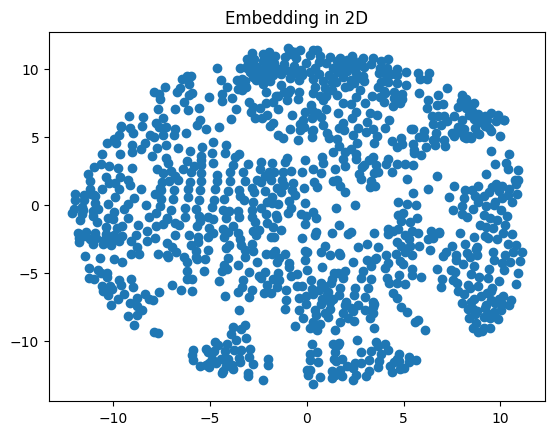

In [ ]:
plt.scatter(embedding[:,0], embedding[:,1])
plt.title('Embedding in 2D')
plt.show()

In [19]:
# DOES NOT WORK

def compute_pairwise_distances(graph, patch_indeces):
    
    '''Function that takes a graph and the starting node and returns a list of distances 
    from the starting node to every other node'''
    
    # Generate a quadratic dataframe for the pairwise distances between all points, label the columns and rows accordingly
    pairwise_distances = pd.DataFrame(np.zeros((len(patch_indeces),len(patch_indeces))))
    pairwise_distances.columns = patch_indeces
    pairwise_distances.index = patch_indeces
    
    for point in patch_indeces: 
        center = point 
        
        n = len(graph) # How many nodes are in the graph?
        # initialize a dictionary to save the distances of each node from the start node
        dist_from_center = {key:100 for key in graph}  
        # initialize a dictionary to save which node has been visited already
        visited = {key:False for key in graph}      
        # set the distance for the start to be 0
        dist_from_center[center] = 0
        
        for p in range(n):  
            # loop through all the nodes to check which one is not yet visited and has the lowest distance to the current node
            u = -1
            for key in graph:
                # if the node 'key' hasn't been visited and
                # we haven't processed it or the distance we have for it is less
                # than the distance we have to the "start" node
                
                # our start node will be selected first and assigned to u
                if not visited[key] and (u == -1 or dist_from_center[key] < dist_from_center[u]):
                    u = key 
            
            # all the nodes have been visited or we can't reach this node
            if dist_from_center[u] == 1000:
                break
            
            # set the node as visited
            visited[u] = True
            
            # from the current selected node u, check what the distances to the next nodes are and update their dist from center
            # loop through all the points (and their weights) that can be reached from our current node
            for key in graph[u]:
                if dist_from_center[u] + graph[u][key] < dist_from_center[key]:
                    dist_from_center[key]= dist_from_center[u] + graph[u][key]
                    if key in patch_indeces:
                        pairwise_distances.at[center, key] = dist_from_center[key]
                        pairwise_distances.at[key, center] = dist_from_center[key]    
    
    return pairwise_distances



In [ ]:
def compute_pairwise_distances(graph, patch_indeces):
    
    '''Function that takes a graph and a list of point indeces within which to compute the pairwise 
    distances'''

    import numpy as np
    import pandas as pd

    # Generate a quadratic dataframe for the pairwise distances between all points, label the columns and rows accordingly
    pairwise_distances = pd.DataFrame(np.zeros((len(patch_indeces),len(patch_indeces))))
    pairwise_distances.columns = patch_indeces
    pairwise_distances.index = patch_indeces

    for i in range(len(patch_indeces)-1):   
        center = patch_indeces[i]
        #in each iteration, shorten the list of indeces by those already done
        n = len(patch_indeces[i:])    
        # initialize a dictionary to save the distances of each node from the start node
        dist_from_center = {index:100 for index in patch_indeces[i:]}    
        # initialize a dictionary to save which node has been visited already
        visited = {index:False for index in patch_indeces[i:]}
        # set the distance for the start to be 0
        dist_from_center[center] = 0
        
        for p in range(n):  
            # loop through all the nodes to check which one is not yet visited and has the lowest distance to the current node
            u = -1
            for key in patch_indeces[i:]:
                # if the node 'key' hasn't been visited and
                # we haven't processed it or the distance we have for it is less
                # than the distance we have to the "start" node
                # our start node will be selected first and assigned to u
                if not visited[key] and (u == -1 or dist_from_center[key] < dist_from_center[u]):
                    u = key 
                        
            # all the nodes have been visited or we can't reach this node
            if dist_from_center[u] == 1000:
                #print("break")
                break
            
            visited[u] = True # set the node as visited
            
            # from the current selected node u, check what the distances to the next nodes are and update their dist from center
            # loop through all the points (and their weights) that can be reached from our current node
            for key in graph[u]:
                if key in patch_indeces[i:]:
                    if dist_from_center[u] + graph[u][key] < dist_from_center[key]:
                        dist_from_center[key]= dist_from_center[u] + graph[u][key]
                        pairwise_distances.at[center, key] = dist_from_center[key]
                        pairwise_distances.at[key, center] = dist_from_center[key]
        
    return pairwise_distances